In this notebook I will parse in the data from the AMiner repository (https://aminer.org/aminernetwork) which includes the paper informaton for millions of academic papers, and do a interrupted time series regression, as part of a Quasi-experiment. 

The packages we will use for this are Pandas, Pyplot, and StatsModels

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

%matplotlib inline

First, since the data is in a text file with certain tags denoting different pieces of information, we need to get the text into a usable format. To do this I will use pandas, a series of conditionals to determine which tags are present, and file I/O.

In [2]:
def gen():
    with open('AMiner-Paper.txt', 'r',  encoding="utf8") as f:
        datum={}
        citations =0
        row=0
        readFile = f.readlines()
        for line in readFile:
            
            if '#index' in line:
                if bool(datum):
                    datum['citations'] = citations
                    try:
                        for i in range(len(datum['author'])):
                            
                            datum_to_save = datum.copy()
                            datum_to_save['author']=datum['author'][i]
                            datum_to_save['affiliation']=datum['affiliation'][i]
                            yield datum_to_save
                            row+=1
                    except IndexError as e:
                        continue
                    
                    datum={}
                    citations =0
                datum['id'] = line[7:].rstrip()
                
            elif '#*' in line:
                datum['title'] = line[3:].rstrip()
            elif '#@' in line:
                datum['author'] = line[3:].rstrip().rsplit(";")
            elif '#o' in line:
                datum['affiliation'] = line[3:].rstrip().rsplit(";")
            elif '#t' in line:
                datum['year'] = line[3:].rstrip()
            elif '#c' in line:
                datum['venue'] = line[3:].rstrip()
            elif '#%' in line:
                citations +=1
            elif '#!' in line:
                datum['abstract'] = line[3:].rstrip()


data = pd.DataFrame(gen(), columns =('id', 'title', 'author', 'affiliation', 'year', 
                                  'venue', 'citations', 'abstract'))
data['year'] =pd.to_numeric(data['year'], errors = 'coerce').fillna(0)

Two things to note about getting the information in from the test file: there are many papers that are missing informaiton, which I have just filled in with '0' and that I used a generator function to feed as an iterable to the data frame constructor. This version of constructing the data frame is *significantly* faster then other methods I had tried (i.e. creating a blank data frame and appending entries to it, or df.append()).

Now, moving to the interrupted time series, I would like to look at whether the advent, or 'intervention' of widely avaible internet research sources was significant to the amount of ciations that publications were recieving. I will nominally pick 2001 as the year of 'intervention' for when internet academic resources became widely available (it is also when Wikipedia came online). Please note, there are porbably many other years than one could argue should be the intervention, and so I have provided the code to test out all possible hypotheses for anyone who would like to test them.

I will begin with looking at some summary statistics

In [3]:
data.describe()

,year,citations
count,5.276680e+06,5.276680e+06
mean,2.004287e+03,4.453837e+00
std,1.613523e+01,7.850490e+00
min,0.000000e+00,0.000000e+00
25%,2.000000e+03,0.000000e+00
50%,2.007000e+03,0.000000e+00
75%,2.010000e+03,7.000000e+00
max,2.014000e+03,8.060000e+02


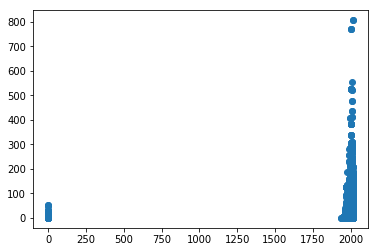

In [4]:
plt.scatter(data["year"], data["citations"])

It looks like we have some years at the value of '0', which means they were missing data, and so we will have to take those out. Also, there are a lot of publications that have been cited 0 times. So, in order to keep more normal distributions in the citations, I will also take these out. So, we will be looking at: of the papers that are cited, have they increased in the number citations that they get following the intervention of widely available internet research resources.

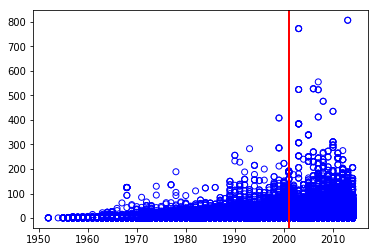

In [5]:
data = data[data["citations"] >0]
data = data[data["year"] >0]

plt.scatter(data["year"], data["citations"], facecolors='none', edgecolors='blue')
plt.axvline(x=2001, color ='red', linewidth=2.0)

(array([  7.63560000e+04,   7.22600000e+03,   5.43000000e+02,
          1.20000000e+02,   2.70000000e+01,   2.60000000e+01,
          1.80000000e+01,   3.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([   1. ,   18.6,   36.2,   53.8,   71.4,   89. ,  106.6,  124.2,
         141.8,  159.4,  177. ]),
 <a list of 10 Patch objects>)

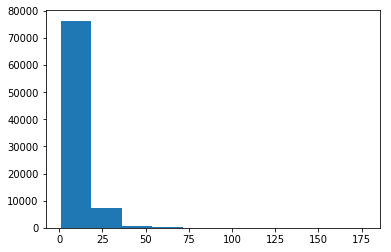

In [6]:
plt.hist(data[data["year"]==2002]['citations'])

{'boxes': [<matplotlib.lines.Line2D at 0x2a2abfe6748>],
 'caps': [<matplotlib.lines.Line2D at 0x2a2abfda0b8>,
 'fliers': [<matplotlib.lines.Line2D at 0x2a2abfc54e0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2a2abfc5dd8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x2a2abfe6320>,
  <matplotlib.lines.Line2D at 0x2a2abfda940>]}

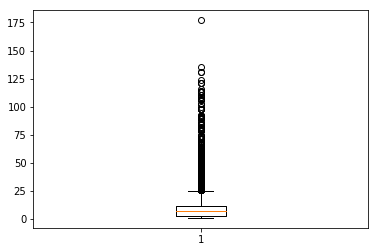

In [7]:
plt.boxplot(data[data["year"]==2002]['citations'])

Looking at the plots, it looks like the assumption of equal variances between years is likely violated, as well as some skewing and non-normality. However, we will push ahead with the interupted time series analysis.

To do the interrupted time series regression we need to keep track of when the intervention occurs, and time since the intervention occured. So, our regression equation will have the form:

$$
E (Y) = \beta_0 + \beta_{treatment} X_i + \beta_{year} Y + \beta_{treatment*year} Y*X_i
$$

Where $Y$ is the year and $X_i$ is a dummy indicator variable for each of the $i$ data points that is 1 when if the paper occurred after 2001 and 0 if before.

In [8]:
data['treatment'] = data['year'] >= 2001
data.drop_duplicates(subset='id')

lm = smf.ols("citations ~ year + treatment + treatment*year", data).fit()
lm.params

Intercept                -402.395045
treatment[T.True]        -278.605919
year                        0.205873
treatment[T.True]:year      0.138145
dtype: float64

In [9]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              citations   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                 1.829e+04
Date:                Fri, 17 Nov 2017   Prob (F-statistic):               0.00
Time:                        14:40:59   Log-Likelihood:            -8.8256e+06
No. Observations:             2438263   AIC:                         1.765e+07
Df Residuals:                 2438259   BIC:                         1.765e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -402.3950      4.346    -92.597      0.000    -410.912    -393.878
treatment[T.True]       -278.6059      5.748    -48.474      0.000    -289.871    -267.341
year                       0.2059      0.002     94.428      0.000       0.202       0.210
treatment[T.True]:year     0.1381      0.003     48.062      0.000       0.133       0.144
==============================================================================
Omnibus:                  3155960.997   Durbin-Watson:                   0.437
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       5347515410.641
Skew:                           6.415   Prob(JB):                         0.00
Kurtosis:                     232.066   Cond. No.                     3.17e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.17e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the model results, it looks both time and intervention are significant with large statistic values and significant $p$-values. However, the adjusted $R$-squared is also quite low, so the model itself does not do a good job explaining the variance in the data. Perhaps a different, nonlinear, method is needed to investigate possible changes is academic publications over time.